In [2]:
# %%
from tensorflow import keras
import glob
import os
import time
import timeit
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.datasets
import numpy as np
import pandas as pd
from scipy.stats import qmc
from matplotlib import rc
from matplotlib import rcParams
import scipy.io as scio 
from PIL import Image,ImageEnhance
from skimage.metrics import normalized_root_mse as NRMSE
import toolz
params = {
    "font.size": 12,
    # "figure.subplot.wspace": 0.2,
    # "figure.subplot.hspace": 0.4,
     "axes.titlesize": 12,   #
    "axes.labelsize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    'lines.linewidth': 2,
    "legend.loc": 'best',
    "figure.autolayout": False
}
rcParams.update(params)
fid = 0
physical_devices = tf.config.list_physical_devices()
for dev in physical_devices:
    print(dev)
print("tf version:", tf.__version__)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
tf version: 2.13.1


In [3]:
# %%
trainmodel=False
filebase='./saved_model/cVAE/'
os.makedirs(filebase, exist_ok=True)



In [4]:
# %%
@keras.saving.register_keras_serializable(name="attention_layer")
class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)  

        self.norm = layers.GroupNormalization(groups=groups)
        #self.norm = layers.BatchNormalization()
        self.query = layers.Dense(units)
        self.key = layers.Dense(units)
        self.value = layers.Dense(units)
        self.proj = layers.Dense(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs) # b*h*w*unit
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)
        #equivalent: [hw X C] * [hw X C]^T, eliminate the index of c
        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])
        #equivalent: [hw X hw] * [hw X c]
        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)# how to use attention layer for imags
        proj = self.proj(proj)
        return inputs + proj
    
@keras.saving.register_keras_serializable(name="resiBlock")
class ResidualBlock(layers.Layer):
    """Residual block.

    Args:
        channel: Number of channels in the convolutional layers
        groups: Number of groups to be used for GroupNormalization layer
        activation_fn: Activation function to be used
    """

    def __init__(self, channel, groups=8, activation_fn=keras.activations.swish,**kwargs):
        self.channel = channel
        self.groups = groups
        self.activation_fn = activation_fn
        super().__init__(**kwargs)
        self.shortcut = layers.Conv2D(channel, kernel_size=1) 
        self.norm1 = layers.GroupNormalization(groups=groups)#layers.BatchNormalization()# 
        
        self.conv1 = layers.Conv2D(channel, kernel_size=3, padding="same")
        self.norm2 =layers.GroupNormalization(groups=groups)# layers.BatchNormalization()# 
        self.conv2 = layers.Conv2D(channel, kernel_size=3, padding="same")
        self.addlayer=layers.Add()
        self.dropout=layers.Dropout(0.2)
    def call(self, inputs):
        x=inputs
        input_c = x.shape[3]
        if input_c == self.channel:
            residual = x
        else:    
            residual = self.shortcut(x)
        x=self.norm1(x)
        x=self.activation_fn(x)
        x=self.conv1(x)
        x=self.norm2(x)
        x=self.activation_fn(x)
        x=self.conv2(x)
        x=self.addlayer([x,residual])
        x=self.dropout(x)
        return x
    
    def get_config(self):
        # Get the base config from the superclass
        config = super().get_config()
        # Update it with the custom arguments
        config.update({
            "groups": self.groups,
            "channel": self.channel,
        })
        return config

@keras.saving.register_keras_serializable(name="DownSample")
class DownSample(layers.Layer):
    def __init__(self, channel, **kwargs):
        self.channel = channel
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(
            channel, kernel_size=3, strides=2, padding="same"
        )

    def call(self, inputs):
        return self.conv(inputs)
    
@keras.saving.register_keras_serializable(name="UpSample")
class UpSample(layers.Layer):
    def __init__(self, channel, interpolation="nearest", **kwargs):
        self.channel = channel
        self.interpolation = interpolation
        super().__init__(**kwargs)
        self.upsample = layers.UpSampling2D(size=2, interpolation=interpolation)
        self.conv = layers.Conv2D(
            channel, kernel_size=3, padding="same"
        )

    def call(self, inputs):
        x = self.upsample(inputs)
        x = self.conv(x)
        return x

In [6]:
# %%
forw_filebase='./saved_model/forward_model/'
forw_model=tf.keras.models.load_model(os.path.join(forw_filebase,'saved_model.keras'),compile=False)


In [7]:
# %%

data_path='./training_data'
data_mat=scio.loadmat((os.path.join(data_path, "data64X64(75-125mm)(393-503K)ln1+gs1.mat")))
input_data_raw=data_mat['input']
input_data=input_data_raw
out_data=data_mat['output']


In [8]:
# %%
min_max_in = MinMaxScaler(feature_range=(0, 1))
input_norm=min_max_in.fit_transform(input_data)
min_out,max_out =np.min(out_data),np.max(out_data)
out_norm=(out_data/127.5)-1.0

X_train, X_test, Y_train, Y_test = train_test_split(input_norm, out_norm, test_size=0.2, random_state=402)

Y_train_rev=(Y_train+1)*127.5
Y_test_rev=(Y_test+1)*127.5
Y_train_rev=Y_train_rev.astype(np.uint8)
Y_test_rev=Y_test_rev.astype(np.uint8)



In [9]:
# %%
@keras.saving.register_keras_serializable(name="sampling")
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        #epsilon=tf.ones(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def EncoderModel(img_size,
   channel_list,
   has_attention,
   num_res_blocks=2,
   norm_groups=8,
   interpolation="nearest",
   activation_fn=keras.activations.swish,
   first_conv_channels=64,
   latent_dim=2,x_in_n=4,
   num_channel=3):
   x_inputs = keras.Input(shape=(x_in_n,), name='x_inputs')
   y_inputs=keras.Input(shape=(img_size,img_size,num_channel), name='y_inputs')
   x = layers.Conv2D(first_conv_channels,kernel_size=(3, 3),padding="same")(y_inputs) # 64*64*16
   skips = [] 
   for i in range(len(channel_list)):
      for _ in range(num_res_blocks):
         x = ResidualBlock(
               channel_list[i], groups=norm_groups, activation_fn=activation_fn)(x)
         if has_attention[i]:
               x = AttentionBlock(channel_list[i], groups=norm_groups)(x)
         skips.append(x)

      if i!=(len(channel_list)-1):
         x = DownSample(channel_list[i])(x)
   
   # MiddleBlock
   x = ResidualBlock(channel_list[-1], groups=norm_groups, activation_fn=activation_fn)(x)
   x = AttentionBlock(channel_list[-1], groups=norm_groups)(x)
   x = ResidualBlock(channel_list[-1], groups=norm_groups, activation_fn=activation_fn)(x) 
   # UpBlock
   for i in reversed(range(len(channel_list))):
      for _ in range(num_res_blocks):
         x = layers.Concatenate(axis=-1)([x, skips.pop()]) 
          
         x = ResidualBlock(
               channel_list[i], groups=norm_groups, activation_fn=activation_fn)(x) 
         if has_attention[i]:
               x = AttentionBlock(channel_list[i], groups=norm_groups)(x)

      if i != 0:
         x = UpSample(channel_list[i], interpolation=interpolation)(x) 
   
   
   x = layers.GroupNormalization(groups=norm_groups)(x)
   x = activation_fn(x)
   x = layers.Conv2D(1, (3, 3),strides=(2,2), padding="valid")(x) 
   x = activation_fn(x)


   d=layers.Flatten()(x)
   d=layers.Dense(100, activation='relu')(d)
   d=layers.Dense(10, activation='relu')(d)
   x=layers.Concatenate(axis=1)([x_inputs, d])
   x=layers.Dense(10, activation='tanh')(x)
   x=layers.Dense(10, activation='tanh')(x)
   x=layers.Dense(10, activation='tanh')(x)
   x=layers.Dense(10, activation='tanh')(x)
   mean = layers.Dense(latent_dim, name='mean')(x)
   log_var = layers.Dense(latent_dim, name='log_var')(x)
   latent = Sampling()([mean, log_var])
   model = tf.keras.Model([x_inputs,y_inputs], [mean, log_var, latent], name="Encoder")
   return model


def DecoderModel(
   img_size,
   channel_list,
   has_attention,
   num_res_blocks=2,
   norm_groups=8,
   interpolation="nearest",
   activation_fn=keras.activations.swish,
   first_conv_channels=64,
   latent_dim=2,x_out_n=4,
   num_channel=3):
   z_inputs = keras.Input(shape=(latent_dim,), name='z_inputs')
   y_inputs=keras.Input(shape=(img_size,img_size,num_channel), name='y_inputs')
   x = layers.Conv2D(first_conv_channels,kernel_size=(3, 3),padding="same")(y_inputs) # 64*64*16

   skips=[]
   for i in range(len(channel_list)):
      for _ in range(num_res_blocks):
         x = ResidualBlock(
               channel_list[i], groups=norm_groups, activation_fn=activation_fn)(x)
         if has_attention[i]:
               x = AttentionBlock(channel_list[i], groups=norm_groups)(x)
         skips.append(x)

      if i!=(len(channel_list)-1):
         x = DownSample(channel_list[i])(x)
   
   # MiddleBlock
   x = ResidualBlock(channel_list[-1], groups=norm_groups, activation_fn=activation_fn)(x)
   x = AttentionBlock(channel_list[-1], groups=norm_groups)(x)
   x = ResidualBlock(channel_list[-1], groups=norm_groups, activation_fn=activation_fn)(x) 
   # UpBlock
   for i in reversed(range(len(channel_list))):
      for _ in range(num_res_blocks):
         x = layers.Concatenate(axis=-1)([x, skips.pop()])
          
         x = ResidualBlock(
               channel_list[i], groups=norm_groups, activation_fn=activation_fn)(x) 
         if has_attention[i]:
               x = AttentionBlock(channel_list[i], groups=norm_groups)(x)

      if i != 0:
         x = UpSample(channel_list[i], interpolation=interpolation)(x) 
   x = layers.GroupNormalization(groups=norm_groups)(x)
   x = activation_fn(x)
   x = layers.Conv2D(1, (3, 3),strides=(2,2), padding="valid")(x) 
   x = activation_fn(x)


   d=layers.Flatten()(x)
   d=layers.Dense(100, activation='relu')(d)
   d=layers.Dense(50, activation='relu')(d)
   xx=layers.Concatenate(axis=1)([z_inputs, d])
   d=layers.Dense(25, activation='relu')(xx)
   d=layers.Dense(25, activation='relu')(d)
   d=layers.Dense(25, activation='relu')(d)
   d=layers.Dense(25, activation='relu')(d)
   d=layers.Dense(25, activation='relu')(d)
   X_out=layers.Dense(x_out_n, activation='sigmoid')(d)
   model = tf.keras.Model([z_inputs,y_inputs], X_out, name="Decoder") 
   return model



In [10]:
# %%
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x_inp,y_inp=data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([x_inp,y_inp])
            reconstruction = self.decoder([z,y_inp])
            reconstruction_loss=tf.reduce_mean(tf.square(x_inp - reconstruction), axis=1)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }




In [11]:
# %%
img_size=64
first_conv_channels = 16
channel_multiplier = [1, 2, 4, 8]
channel_list = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks=1
norm_groups=8
nX=4
latent_dim=2

 # encoder
filename_encoder=os.path.join(filebase,'encoder.keras')
if os.path.isfile(filename_encoder):
    encoder=tf.keras.models.load_model(filename_encoder,compile=False)
else:
   encoder = EncoderModel(
   img_size,
   channel_list,
   has_attention,
   num_res_blocks=num_res_blocks,
   norm_groups=norm_groups,
   interpolation="nearest",
   activation_fn=keras.activations.swish,
   first_conv_channels=first_conv_channels,
   latent_dim=latent_dim,x_in_n=nX,
   num_channel=3)
   
   tf.keras.utils.plot_model(encoder, 
                                  to_file=filebase+'encoder.png',
                                  show_shapes=True,show_layer_activations=False)
   
encoder.summary()

# decoder
filename_decoder=os.path.join(filebase,'decoder.keras')
if os.path.isfile(filename_decoder):
    decoder=tf.keras.models.load_model(filename_decoder)
else:
    decoder = DecoderModel(
    img_size,
    channel_list,
    has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
    first_conv_channels=first_conv_channels,
    latent_dim=latent_dim,x_out_n=nX,
    num_channel=3)

    tf.keras.utils.plot_model(decoder, 
                                    to_file=filebase+'decoder.png',
                                    show_shapes=True,show_layer_activations=False)
    
decoder.summary()
vae = VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))


Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 y_inputs (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 64, 64, 16)           448       ['y_inputs[0][0]']            
                                                                                                  
 residual_block (ResidualBl  (None, 64, 64, 16)           4704      ['conv2d_36[0][0]']           
 ock)                                                                                             
                                                                                                  
 down_sample (DownSample)    (None, 32, 32, 16)           2320      ['residual_block[0][0]']

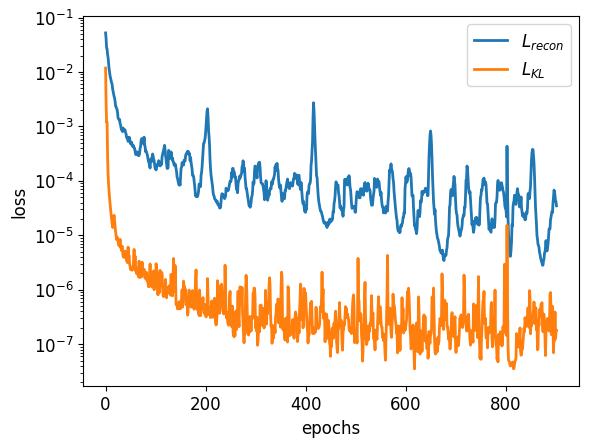

In [12]:
# %%
if trainmodel:
    K.set_value(vae.optimizer.lr, 5e-4)
    start_time = timeit.default_timer()
    h = vae.fit([X_train,Y_train], epochs=900, verbose=2, batch_size=128)
    stop_time = timeit.default_timer()
    print('\n \n')
    print('training Run time so far: ', round(
            stop_time - start_time, 2), '(s)')
    encoder.save(filename_encoder)
    decoder.save(filename_decoder)

    if os.path.isfile(filebase+'losses.csv'):
        df_history = pd.read_csv(filebase+'losses.csv', index_col=0)
        df_history_total = {key: df_history[key].tolist(
        ) + (h.history)[key] for key in h.history}

    else:
        df_history_total = h.history
    df_history_total = pd.DataFrame(df_history_total)
    df_history_total.to_csv(filebase+'losses.csv')

df_history_total=pd.read_csv(filebase+'losses.csv', index_col=0)
fid+=1
fig=plt.figure(num=fid)
ax=plt.subplot(1,1,1)
ax.semilogy(df_history_total['reconstruction_loss'], label=r'$L_{recon}$')
ax.semilogy(df_history_total['kl_loss'], label=r'$L_{KL}$')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(loc='best')


In [13]:
# %%
def calculate_diff_rgb(images_true, images_test,normalization='min-max'):
    diffs=[]
    for (img_true,img_test) in (zip(images_true, images_test)):
        diff=NRMSE(img_true,img_test,normalization=normalization)
        diffs.append(diff)
    # Initialize variables to store SSIM values for each channel
    return np.array(diffs)



In [14]:
# %%
def ModelEvaluation(X,Y,seed=42):
    #YY=np.repeat(Y,numZ,axis=0)
    np.random.seed(seed=seed)
    YY=Y
    Z=np.random.normal(0,1,size=(YY.shape[0],latent_dim))
    X_out=(decoder([Z,YY])).numpy()
    YY_de=(forw_model(X_out)).numpy()
    YY_de=np.clip((YY_de+1)*127.5,0,255).astype(dtype=np.uint8)
    YY=np.clip((YY+1)*127.5,0,255).astype(dtype=np.uint8)
    diffs=calculate_diff_rgb(YY,YY_de)
    return X_out,YY_de,diffs
    
    


NRMSE: mean = 0.1858, std = 0.0995


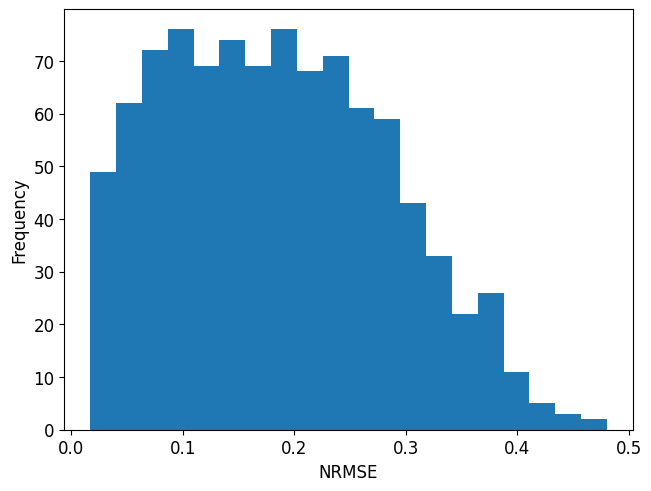

In [16]:
# %%
X_out_test,Y_design_test,NRMSE_test=ModelEvaluation(X_test,Y_test)
x_design_test=min_max_in.inverse_transform(X_out_test)
id_sort_test=np.argsort(NRMSE_test)

fid+=1
fig=plt.figure(num=fid,constrained_layout=True)
ax=plt.subplot(1,1,1)
_=ax.hist(NRMSE_test,bins=20)
ax.set_xlabel('NRMSE')
ax.set_ylabel('Frequency')
print('NRMSE: mean = %.4f, std = %.4f'%(np.mean(NRMSE_test),np.std(NRMSE_test)))

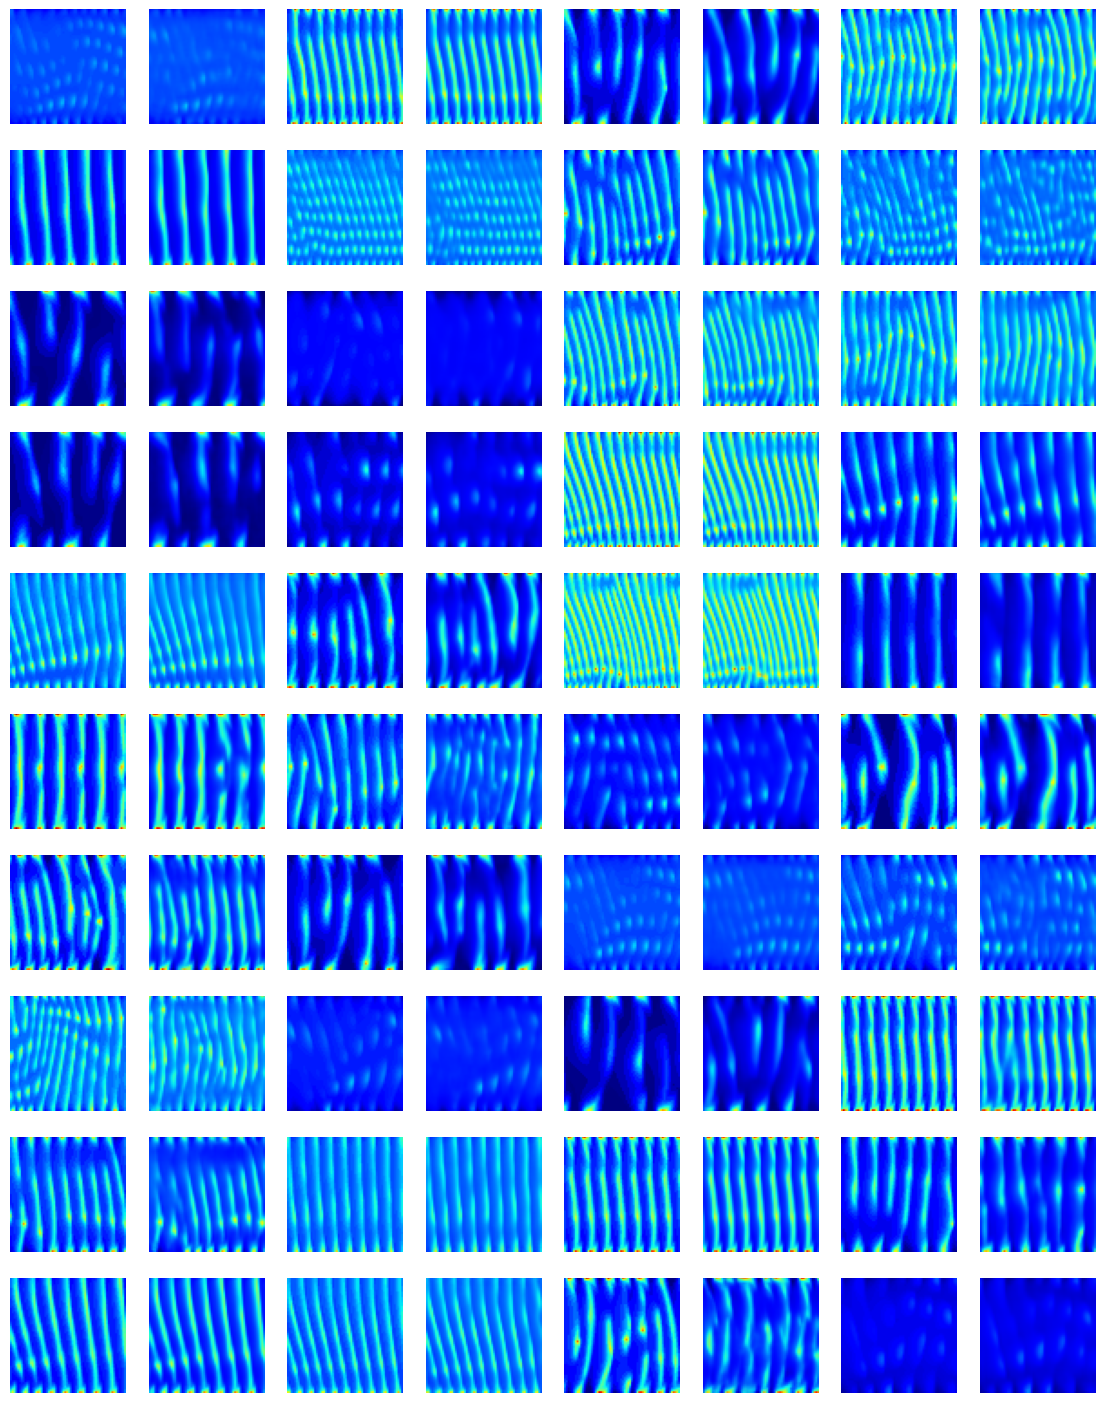

In [18]:
# %%



fid+=1
plt.close()
fig=plt.figure(num=fid,figsize=(14,18))
Ncol,Nrow=8,10
numfig=int(Ncol*Nrow/2)
Yplot_target=Y_test_rev
Yplot_design=Y_design_test
np.random.seed(seed=12)
ids=np.random.randint(0,len(Yplot_target),numfig) 
for i, (img_t,img_d) in enumerate(zip(Yplot_target[ids],Yplot_design[ids])):
    ax=plt.subplot(Nrow,Ncol,2*i+1)
    ax.imshow(img_t)
    ax.axis('scaled')
    ax.axis('off')
    ax=plt.subplot(Nrow,Ncol,2*i+2)
    ax.imshow(img_d)
    ax.axis('scaled')
    ax.axis('off')

test_validate={'Yplot_target':Yplot_target[ids],'Yplot_design_vae':Yplot_design[ids]}
scio.savemat(filebase+'test_validate.mat',test_validate)


In [21]:
# %%
def design_ontest(id,scramble=True):
    global fid
    Ytarg=Y_test[id:id+1,:]
    Xtarg=min_max_in.inverse_transform(X_test[id:id+1,:])
    tol=0.4
    scale=64
    numZ=1024
    numplot=24
    sampler = qmc.Sobol(d=latent_dim,scramble=scramble)
    sample_data = sampler.random(n=(numZ))
    l_bounds = -scale*np.ones((latent_dim,))
    u_bounds = scale*np.ones((latent_dim,))
    Z=qmc.scale(sample_data, l_bounds, u_bounds)

    YY=np.repeat(Ytarg,numZ,axis=0)

    X_out=decoder.predict([Z,YY],batch_size=Z.shape[0], verbose=2)
    YY_de=forw_model.predict(X_out,batch_size=X_out.shape[0], verbose=2)
    YY_de=np.clip((YY_de+1)*127.5,0,255).astype(dtype=np.uint8)
    YY=np.clip((YY+1)*127.5,0,255).astype(dtype=np.uint8)
    NRMSE_diff=calculate_diff_rgb(YY,YY_de)
    x_design=min_max_in.inverse_transform(X_out)
    indices = NRMSE_diff < tol
    NRMSE_diff=NRMSE_diff[indices]
    x_design=x_design[indices]

    id_sort=np.argsort(NRMSE_diff)
    fid+=1
    fig=plt.figure(num=fid,figsize=(8,3))

    ax=plt.subplot(1,5,1)
    ax.imshow(YY[0])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title('Target')

    ax=plt.subplot(1,5,2)
    idx=id_sort[0]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f'%NRMSE_diff[idx])

    ax=plt.subplot(1,5,3)
    idx=id_sort[int(id_sort.shape[0]*0.3)]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f'%NRMSE_diff[idx])

    ax=plt.subplot(1,5,4)
    idx=id_sort[int(id_sort.shape[0]*0.6)]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f'%NRMSE_diff[idx])

    ax=plt.subplot(1,5,5)
    idx=id_sort[-1]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f'%NRMSE_diff[idx])

    fid+=1
    fig=plt.figure(num=fid,figsize=(8,3),constrained_layout=True)
    ax=plt.subplot(1,2,1)
    ax.set_ylabel(r'$\alpha_0~[\%]$')
    ax.set_xlabel(r'$T_0~[^oC]$')
    sc=ax.scatter(x_design[:,0],x_design[:,1]*100,c=NRMSE_diff, cmap='hot',s=10)
    ax.scatter(Xtarg[:,0],Xtarg[:,1]*100,c='r', marker='*',s=100,label='target')
    ax.scatter(x_design[id_sort[0],0],x_design[id_sort[0],1]*100,c='b', marker='d',s=100,label='best')
    ax.legend()
    ax=plt.subplot(1,2,2)
    ax.set_ylabel(r'$d$')
    ax.set_xlabel(r'$h_L~[\frac{W}{K m^2}]$')
    sc=ax.scatter(x_design[:,2],x_design[:,3],c=NRMSE_diff, cmap='hot',s=10)
    ax.scatter(Xtarg[:,2],Xtarg[:,3],c='r', marker='*',s=100,label='target')
    ax.scatter(x_design[id_sort[0],2],x_design[id_sort[0],3],c='b', marker='d',s=100,label='best')
    ax.legend()
    cbar=plt.colorbar(sc)
    cbar.set_label('NRMSE')
    return x_design[id_sort[0]]
    



id:  [623 241 143]
1/1 - 4s - 4s/epoch - 4s/step
1/1 - 1s - 1s/epoch - 1s/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
best_designs:  [array([38.162075  ,  0.09432963, 19.177277  ,  0.49350154], dtype=float32), array([21.235966  ,  0.07738768,  5.117967  ,  0.6692128 ], dtype=float32), array([2.9001776e+01, 2.2660801e-02, 6.1103127e+01, 4.9419942e-01],
      dtype=float32)]


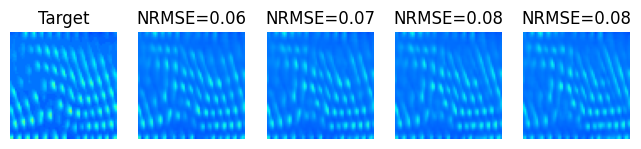

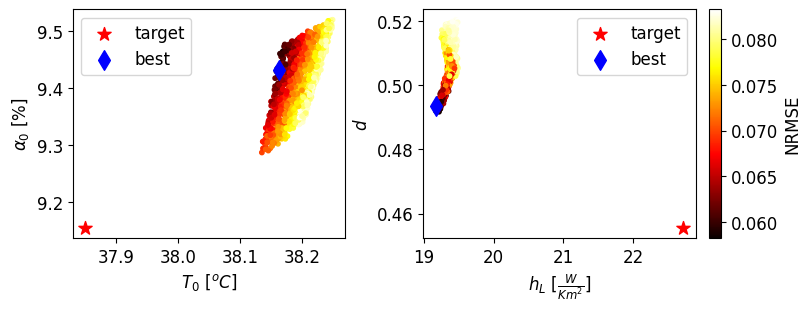

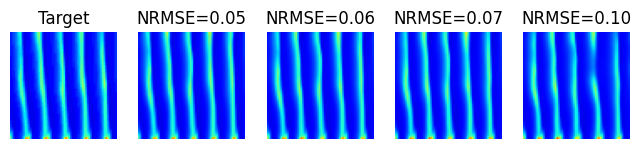

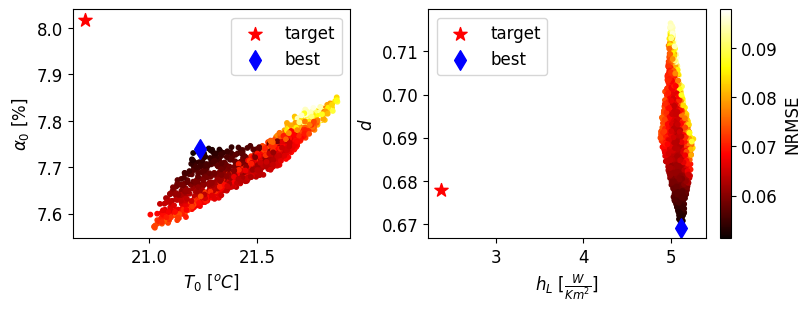

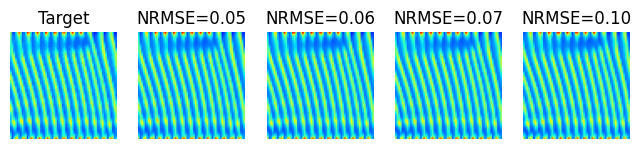

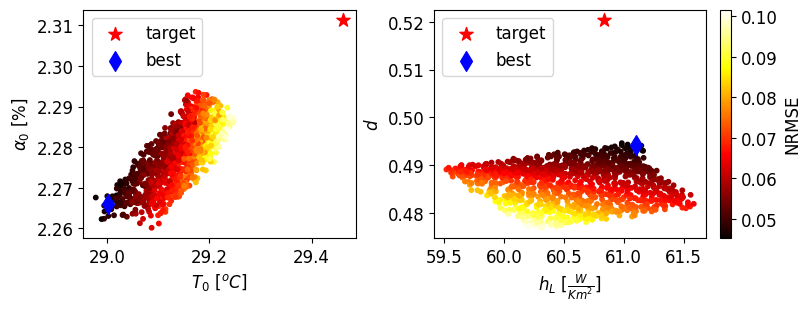

In [22]:
# %%
# seed=9,13,15
np.random.seed(seed=17)
id=np.random.randint(0,Y_test.shape[0],size=3)
print('id: ',id)
best_designs=[]
for i in id:
    best_designs.append(design_ontest(i)) 

print('best_designs: ',best_designs)

In [23]:
# %%
def design_ondemand(img,scramble=False):
    global fid
    tol=1
    Ytarg=img[None,:,:,:]

    scale=64
    numZ=1024
    sampler = qmc.Sobol(d=latent_dim,scramble=scramble)
    sample_data = sampler.random(n=(numZ))
    l_bounds = -scale*np.ones((latent_dim,))
    u_bounds = scale*np.ones((latent_dim,))
    Z=qmc.scale(sample_data, l_bounds, u_bounds)

    YY=np.repeat(Ytarg/127.5-1,numZ,axis=0)
    start_time = timeit.default_timer()
    X_out=decoder([Z,YY]).numpy()
    YY_de=forw_model(X_out).numpy()
    stop_time = timeit.default_timer()
    print('prediction time: %f s'%(stop_time-start_time))
    YY_de=np.clip((YY_de+1)*127.5,0,255).astype(dtype=np.uint8)
    YY=np.clip((YY+1)*127.5,0,255).astype(dtype=np.uint8)
    NRMSE_diff=calculate_diff_rgb(YY,YY_de)
    x_design=min_max_in.inverse_transform(X_out)
    id_sort=np.argsort(NRMSE_diff)
    fid+=1
    fig=plt.figure(num=fid,figsize=(8,3))

    ax=plt.subplot(1,5,1)
    ax.imshow(Ytarg[0])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title('Target')

    ax=plt.subplot(1,5,2)
    idx=id_sort[0]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f'%NRMSE_diff[idx])

    ax=plt.subplot(1,5,3)
    idx=id_sort[int(id_sort.shape[0]*0.3)]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f'%NRMSE_diff[idx])

    ax=plt.subplot(1,5,4)
    idx=id_sort[int(id_sort.shape[0]*0.6)]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f'%NRMSE_diff[idx])

    ax=plt.subplot(1,5,5)
    idx=id_sort[-1]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f'%NRMSE_diff[idx])
    
    
    fid+=1
    fig=plt.figure(num=fid,figsize=(8,3),constrained_layout=True)
    ax=plt.subplot(1,2,1)
    ax.set_ylabel(r'$\alpha_0~[\%]$')
    ax.set_xlabel(r'$T_0~[^oC]$')
    sc=ax.scatter(x_design[:,0],x_design[:,1]*100,c=NRMSE_diff, cmap='hot',s=10)
    ax.scatter(x_design[id_sort[0],0],x_design[id_sort[0],1]*100,c='b', marker='d',s=100,label='best')
    ax.legend()
    ax=plt.subplot(1,2,2)
    ax.set_ylabel(r'$d$')
    ax.set_xlabel(r'$h_L~[\frac{W}{K m^2}]$')
    sc=ax.scatter(x_design[:,2],x_design[:,3],c=NRMSE_diff, cmap='hot',s=10)
    ax.scatter(x_design[id_sort[0],2],x_design[id_sort[0],3],c='b', marker='d',s=100,label='best')
    ax.legend()
    cbar=plt.colorbar(sc)
    cbar.set_label('NRMSE')
    return x_design[id_sort[0]]

    

prediction time: 0.404168 s
best_designs:  [array([38.162075  ,  0.09432963, 19.177277  ,  0.49350154], dtype=float32), array([21.235966  ,  0.07738768,  5.117967  ,  0.6692128 ], dtype=float32), array([2.9001776e+01, 2.2660801e-02, 6.1103127e+01, 4.9419942e-01],
      dtype=float32)]


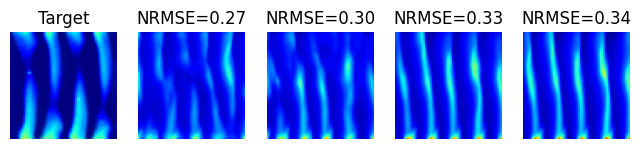

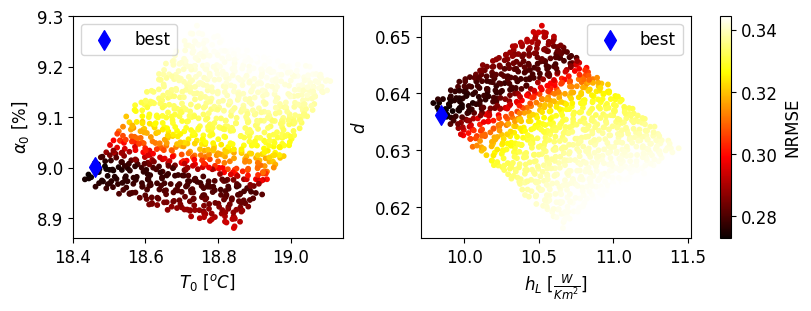

In [24]:
# %%
img=scio.loadmat('./training_data/ex15mm_v1_mold3.mat')['image'].astype(np.uint8)
x_design=design_ondemand(img,scramble=False)
print('best_designs: ',best_designs)

prediction time: 0.402341 s
best_designs:  [array([38.162075  ,  0.09432963, 19.177277  ,  0.49350154], dtype=float32), array([21.235966  ,  0.07738768,  5.117967  ,  0.6692128 ], dtype=float32), array([2.9001776e+01, 2.2660801e-02, 6.1103127e+01, 4.9419942e-01],
      dtype=float32)]


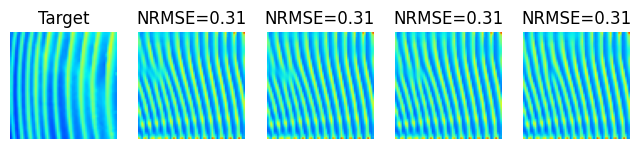

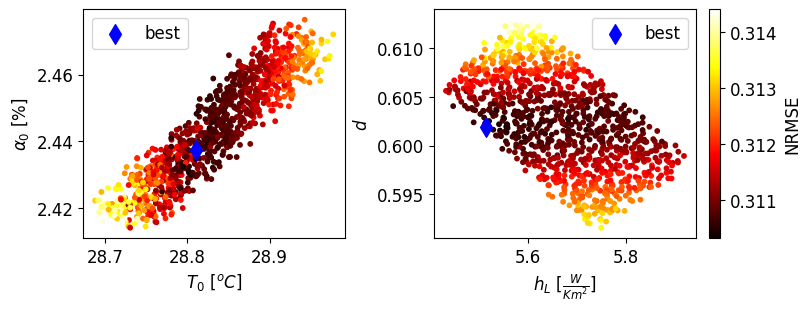

In [25]:
# %%


img=scio.loadmat('./training_data/scpicule.mat')['image'].astype(np.uint8)
x_design=design_ondemand(img,scramble=False)
print('best_designs: ',best_designs)

prediction time: 0.392766 s
best_designs:  [array([38.162075  ,  0.09432963, 19.177277  ,  0.49350154], dtype=float32), array([21.235966  ,  0.07738768,  5.117967  ,  0.6692128 ], dtype=float32), array([2.9001776e+01, 2.2660801e-02, 6.1103127e+01, 4.9419942e-01],
      dtype=float32)]


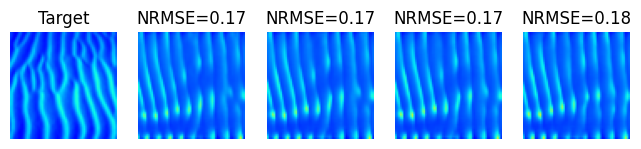

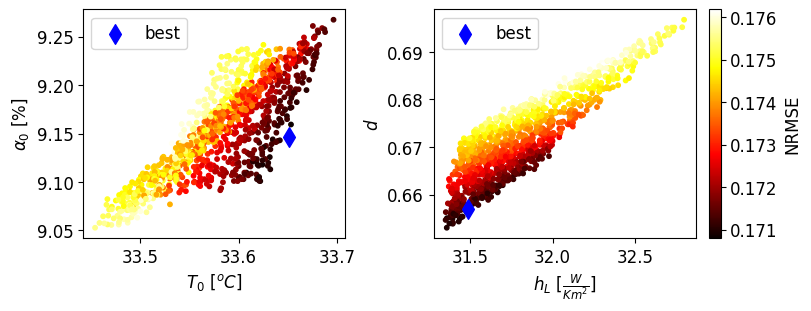

In [26]:
# %%
img=scio.loadmat('./training_data/sand.mat')['image'].astype(np.uint8)
x_design=design_ondemand(img,scramble=False)
print('best_designs: ',best_designs)